# Generically access model output

In [1]:
import cf_xarray
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import xcmocean
import cmocean.cm as cmo
import extract_model as em

## ROMS

In [2]:
# open an example dataset from xarray's tutorials
ds = xr.tutorial.open_dataset('ROMS_example.nc', chunks={'ocean_time': 1})
# normally could run the `preprocess` code as part of reading in the dataset
# but with the tutorial model output, run it separately:
ds = em.preprocess(ds)
ds

<xarray.Dataset>
Dimensions:     (ocean_time: 2, s_rho: 30, eta_rho: 191, xi_rho: 371)
Coordinates:
    Cs_r        (s_rho) float64 dask.array<chunksize=(30,), meta=np.ndarray>
    lon_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(191, 371), meta=np.ndarray>
    hc          float64 20.0
    h           (eta_rho, xi_rho) float64 dask.array<chunksize=(191, 371), meta=np.ndarray>
    lat_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(191, 371), meta=np.ndarray>
    Vtransform  int32 2
  * ocean_time  (ocean_time) datetime64[ns] 2001-08-01 2001-08-08
  * s_rho       (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
  * xi_rho      (xi_rho) int64 0 1 2 3 4 5 6 7 ... 364 365 366 367 368 369 370
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 7 ... 184 185 186 187 188 189 190
    z_rho       (ocean_time, s_rho, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 30, 191, 371), meta=np.ndarray>
Data variables:
    salt        (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 30, 191, 371), meta=np.ndarray>
    zeta        (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 191, 371), meta=np.ndarray>
Attributes: (12/34)
    file:              ../output_20yr_obc/2001/ocean_his_0015.nc
    format:            netCDF-4/HDF5 file
    Conventions:       CF-1.4
    type:              ROMS/TOMS history file
    title:             TXLA ROMS hindcast run with dyes and oxygen
    rst_file:          ../output_20yr_obc/2001/ocean_rst.nc
    ...                ...
    compiler_flags:    -heap-arrays -fp-model fast -mt_mpi -ip -O3 -msse2 -free
    tiling:            010x012
    history:           Tue Jul 24 11:04:43 2018: /opt/nco/ncks -D 4 -t 8 /cop...
    ana_file:          /home/d.kobashi/TXLA_ROMS_reana/Functionals/ana_btflux...
    CPP_options:       TXLA2, ANA_BPFLUX, ANA_BSFLUX, ANA_BTFLUX, ANA_NUDGCOE...
    NCO:               netCDF Operators version 4.7.6-alpha04 (Homepage = htt...

Note that the preprocessing code sets up a ROMS dataset so that it can be used with `cf-xarray`. For example, axis and coordinate variables have been identified:

In [3]:
ds.cf

Coordinates:
- CF Axes: * X: ['xi_rho']
           * Y: ['eta_rho']
           * Z: ['s_rho']
           * T: ['ocean_time']

- CF Coordinates:   longitude: ['lon_rho']
                    latitude: ['lat_rho']
                    vertical: ['z_rho']
                  * time: ['ocean_time']

- Cell Measures:   area, volume: n/a

- Standard Names:   latitude: ['lat_rho']
                    longitude: ['lon_rho']
                  * ocean_s_coordinate_g2: ['s_rho']
                  * time: ['ocean_time']

- Bounds:   n/a

Data Variables:
- Cell Measures:   area, volume: n/a

- Standard Names:   sea_surface_elevation: ['zeta']
                    sea_water_practical_salinity: ['salt']

- Bounds:   n/a

Variable to use, by standard_name:

In [4]:
zeta = 'sea_surface_elevation'
salt = 'sea_water_practical_salinity'

### Subset numerical domain

Use `.em.sub_grid()` to narrow the model area down using a bounding box on a Dataset which respects the horizontal structure of multiple grids. Currently only is relevant for ROMS models but will run on any ROMS model or models with a single longitude/latitude set of coordinates.

Resulting area of model will not be exactly the bounding box if the domain is curvilinear.

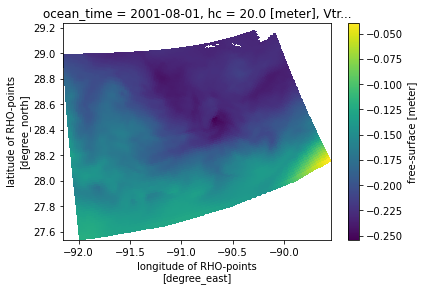

In [5]:
ds_sub = ds.em.sub_grid([-92, 27, -90, 29])
ds_sub.cf[zeta].cf.isel(T=0).cf.plot(x='longitude', y='latitude')

Note that this is an unusual ROMS Dataset because it has only one horizontal grid.

In [6]:
ds_sub

<xarray.Dataset>
Dimensions:     (ocean_time: 2, s_rho: 30, eta_rho: 100, xi_rho: 144)
Coordinates:
    Cs_r        (s_rho) float64 dask.array<chunksize=(30,), meta=np.ndarray>
    lon_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(100, 144), meta=np.ndarray>
    hc          float64 20.0
    h           (eta_rho, xi_rho) float64 dask.array<chunksize=(100, 144), meta=np.ndarray>
    lat_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(100, 144), meta=np.ndarray>
    Vtransform  int32 2
  * ocean_time  (ocean_time) datetime64[ns] 2001-08-01 2001-08-08
  * s_rho       (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
  * xi_rho      (xi_rho) int64 98 99 100 101 102 103 ... 236 237 238 239 240 241
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98 99
    z_rho       (ocean_time, s_rho, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 30, 100, 144), meta=np.ndarray>
Data variables:
    salt        (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 30, 100, 144), meta=np.ndarray>
    zeta        (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 100, 144), meta=np.ndarray>
Attributes: (12/34)
    file:              ../output_20yr_obc/2001/ocean_his_0015.nc
    format:            netCDF-4/HDF5 file
    Conventions:       CF-1.4
    type:              ROMS/TOMS history file
    title:             TXLA ROMS hindcast run with dyes and oxygen
    rst_file:          ../output_20yr_obc/2001/ocean_rst.nc
    ...                ...
    compiler_flags:    -heap-arrays -fp-model fast -mt_mpi -ip -O3 -msse2 -free
    tiling:            010x012
    history:           Tue Jul 24 11:04:43 2018: /opt/nco/ncks -D 4 -t 8 /cop...
    ana_file:          /home/d.kobashi/TXLA_ROMS_reana/Functionals/ana_btflux...
    CPP_options:       TXLA2, ANA_BPFLUX, ANA_BSFLUX, ANA_BTFLUX, ANA_NUDGCOE...
    NCO:               netCDF Operators version 4.7.6-alpha04 (Homepage = htt...

### Subset to a horizontal box

Use `.em.sub_bbox()` to narrow the model area down using a bounding box on either a Dataset or DataArray. There is no expectation of multiple horizontal grids having the "correct" relationship to each other.

#### Dataset

In the case of a Dataset, all map-based variables are filtered using the same bounding box.

In [7]:
ds.em.sub_bbox([-92, 27, -90, 29], drop=True).cf[salt].cf.isel(T=0).cf.sel(Z=0, method='nearest')

<xarray.DataArray 'salt' (eta_rho: 100, xi_rho: 144)>
dask.array<getitem, shape=(100, 144), dtype=float32, chunksize=(100, 144), chunktype=numpy.ndarray>
Coordinates:
    ocean_time  datetime64[ns] 2001-08-01
    s_rho       float64 -0.01667
  * xi_rho      (xi_rho) int64 98 99 100 101 102 103 ... 236 237 238 239 240 241
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98 99
Attributes:
    long_name:      salinity
    time:           ocean_time
    field:          salinity, scalar, series
    standard_name:  sea_water_practical_salinity

#### DataArray

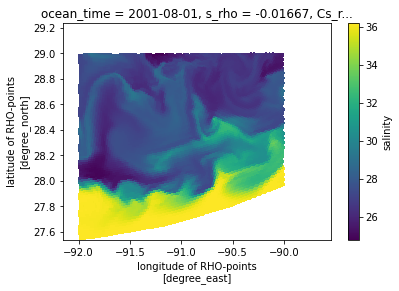

In [8]:
ds.cf[salt].em.sub_bbox([-92, 27, -90, 29], drop=True).cf.isel(T=0, Z=-1).cf.plot(x='longitude', y='latitude')

### grid point (interpolation and selecting nearest)

Interpolate to a single existing horizontal grid point (and any additional depth and time values for that location) and compare it with method selecting the nearest point to demonstrate we get the same value.

In [9]:
%%time

varname = salt

# Set up a single lon/lat location
j, i = 50, 10
longitude = float(ds.cf[varname].cf['longitude'][j,i])
latitude = float(ds.cf[varname].cf['latitude'][j,i])

# Interpolation
da_out = ds.cf[varname].em.interp2d(longitude, latitude)

# Selection of nearest location in 2D
da_check = ds.cf[varname].em.sel2dcf(longitude=longitude, latitude=latitude).squeeze()

assert np.allclose(da_out, da_check)

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:455: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


CPU times: user 3.91 s, sys: 122 ms, total: 4.03 s
Wall time: 4.05 s


You could also select a time and/or depth index or interpolate in time and/or depth at the same time:

In [10]:
# Select time index and depth index
ds.cf[varname].em.interp2d(longitude, latitude, iT=0, iZ=0)

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:455: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


<xarray.DataArray 'salt' ()>
dask.array<getitem, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    ocean_time  datetime64[ns] 2001-08-01
    s_rho       float64 -0.9833
    Cs_r        float64 dask.array<chunksize=(), meta=np.ndarray>
    hc          float64 20.0
    Vtransform  int32 2
    lat         float64 28.23
    lon         float64 -93.59
    z_rho       float64 dask.array<chunksize=(), meta=np.ndarray>
Attributes:
    long_name:      salinity
    time:           ocean_time
    field:          salinity, scalar, series
    standard_name:  sea_water_practical_salinity
    regrid_method:  bilinear

In [11]:
ds.cf[varname].cf

Coordinates:
- CF Axes: * X: ['xi_rho']
           * Y: ['eta_rho']
           * Z: ['s_rho']
           * T: ['ocean_time']

- CF Coordinates:   longitude: ['lon_rho']
                    latitude: ['lat_rho']
                    vertical: ['z_rho']
                  * time: ['ocean_time']

- Cell Measures:   area, volume: n/a

- Standard Names:   latitude: ['lat_rho']
                    longitude: ['lon_rho']
                  * ocean_s_coordinate_g2: ['s_rho']
                  * time: ['ocean_time']

- Bounds:   n/a

In [12]:
# Interpolate to time value and depth value
ds.cf[varname].em.interp2d(longitude, latitude, T=ds.cf['T'][0], Z=-10)

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:455: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


<xarray.DataArray 'salt' ()>
dask.array<dask_aware_interpnd, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    s_rho       float64 -0.4475
    Cs_r        float64 dask.array<chunksize=(), meta=np.ndarray>
    hc          float64 20.0
    Vtransform  int32 2
    lat         float64 28.23
    lon         float64 -93.59
    ocean_time  datetime64[ns] 2001-08-01
    z_rho       int64 -10
Attributes:
    long_name:      salinity
    time:           ocean_time
    field:          salinity, scalar, series
    standard_name:  sea_water_practical_salinity
    regrid_method:  bilinear

The interpolation is faster the second time the regridder is used — it is saved by the `extract_model` accessor and reused if the lon/lat locations to be interpolated to are the same. Here we interpolate to salinity and it is faster than it was the first time it was used for interpolation the sea surface elevation.

In [13]:
%%time

varname = zeta

# Set up a single lon/lat location
j, i = 50, 10
longitude = float(ds.cf[varname].cf['longitude'][j,i])
latitude = float(ds.cf[varname].cf['latitude'][j,i])

# Interpolation
da_out = ds.cf[varname].em.interp2d(longitude, latitude)

# Selection of nearest location in 2D
da_check = ds.cf[varname].em.sel2dcf(longitude=longitude, latitude=latitude).squeeze()

assert np.allclose(da_out, da_check)

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:455: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


CPU times: user 1.4 s, sys: 34.3 ms, total: 1.43 s
Wall time: 1.44 s


### not grid point


#### inside domain  (interpolation and selecting nearest)

For a selected location that is not a grid point (so we can't check it exactly), we show here both interpolating to that location horizontally and selecting the nearest point to that location.

The square in the right hand side plot shows the nearest point selected using `.em.sel2d()` and the circle shows the interpolated value at the exact selected location using `.em.interp2d()`.

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:455: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


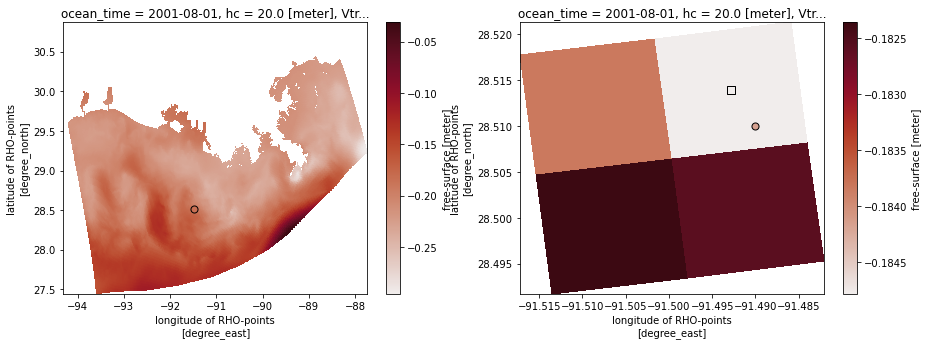

In [14]:
varname = zeta

# sel
longitude = -91.49
latitude = 28.510

# isel
iZ = None
iT = 0
isel = dict(T=iT)

# Interpolation
da_out = ds.cf[varname].em.interp2d(longitude, latitude, iT=iT, iZ=iZ)

# Selection of nearest location in 2D
da_sel = ds.cf[varname].em.sel2dcf(longitude=longitude, latitude=latitude).cf.isel(T=iT).squeeze()

# Plot
cmap = ds.cf[varname].cmo.seq
dacheck = ds.cf[varname].cf.isel(isel)
fig, axes = plt.subplots(1, 2, figsize=(15,5))

dacheck.cmo.cfplot(ax=axes[0], x='longitude', y='latitude')
axes[0].scatter(da_out.cf['longitude'], da_out.cf['latitude'], s=50, c=da_out, 
           vmin=dacheck.min().values, vmax=dacheck.max().values, cmap=cmap, edgecolors='k')

# make smaller area of model to show
# want model output only within the box defined by these lat/lon values
dacheck_min = dacheck.em.sub_bbox([-91.52, 28.49, -91.49, 28.525], drop=True)
dacheck_min.cmo.cfplot(ax=axes[1], x='longitude', y='latitude')
# interpolation
axes[1].scatter(da_out.cf['longitude'], da_out.cf['latitude'], s=50, c=da_out, 
           vmin=dacheck_min.min().values, vmax=dacheck_min.max().values, 
                cmap=cmap, edgecolors='k')
# selection
axes[1].scatter(da_sel.cf['longitude'], da_sel.cf['latitude'], s=50, c=da_sel, 
           vmin=dacheck_min.min().values, vmax=dacheck_min.max().values, 
                cmap=cmap, edgecolors='k', marker='s')


#### outside domain

Don't extrapolate

This is commented out since it purposefully raises an error:
> ValueError: Longitude outside of available domain. Use extrap=True to extrapolate.

In [15]:
# varname = zeta

# # sel
# longitude = -166
# latitude = 48
# sel = dict(longitude=longitude, latitude=latitude)

# # isel
# iZ = 0
# iT = 0
# isel = dict(Z=iZ, T=iT)

# da_out = ds.cf[varname].em.interp2d(longitude, latitude, iT=iT, iZ=iZ, extrap=False)

# da_out

Extrapolate

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:455: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


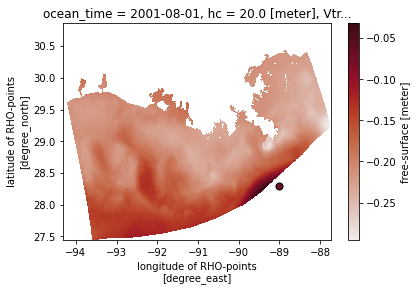

In [16]:
varname = zeta

# sel
longitude = -89
latitude = 28.3
sel = dict(longitude=longitude, latitude=latitude)

# isel
iZ = None
iT = 0
isel = dict(T=iT)

da_out = ds.cf[varname].em.interp2d(longitude, latitude, iT=iT, iZ=iZ, extrap=True)

# plot
cmap = ds.cf[varname].cmo.seq
dacheck = ds.cf[varname].cf.isel(isel)
fig, ax = plt.subplots(1,1)
dacheck.cmo.cfplot(ax=ax, x='longitude', y='latitude')
ax.scatter(da_out.cf['longitude'], da_out.cf['latitude'], s=50, c=da_out, 
           vmin=dacheck.min().values, vmax=dacheck.max().values, cmap=cmap, edgecolors='k')


### points (locstream, interpolation)

Interpolate to unstructured pairs of lon/lat locations instead of grids of lon/lat locations, using `locstream`. Choose grid points so that we can check the accuracy of the results.

In [17]:
varname = zeta

# sel
# this creates 12 pairs of lon/lat points that 
# align with grid points so we can check the 
# interpolation
longitude = ds.cf[varname].cf['longitude'].isel(eta_rho=60, xi_rho=slice(None,None,10))
latitude = ds.cf[varname].cf['latitude'].isel(eta_rho=60, xi_rho=slice(None,None,10))
sel = dict(X=longitude.xi_rho, Y=longitude.eta_rho)

# isel
iZ = None
iT = 0
isel = dict(T=iT)

da_out = ds.cf[varname].em.interp2d(longitude, latitude, iT=iT, iZ=iZ, locstream=True)

# check
da_check = ds.cf[varname].cf.isel(isel).cf.sel(sel)

assert np.allclose(da_out, da_check, equal_nan=True)

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:455: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


It is not currently possible to interpolate in depth with both more than one time and location. 

This cell is commented out because it purposefully returns an error:
> NotImplementedError: Currently it is not possible to interpolate in depth with more than 1 other (time) dimension.

In [18]:
# ds.cf[salt].em.interp2d(longitude, latitude, Z=-10, locstream=True)

### grid of known locations (interpolation)

In [19]:
varname = zeta

# sel
longitude = ds.cf[varname].cf['longitude'][:-50:20,:-200:100]
latitude = ds.cf[varname].cf['latitude'][:-50:20,:-200:100]
sel = dict(X=longitude.xi_rho, Y=longitude.eta_rho)

# isel
iZ = None
iT = 0
isel = dict(T=iT)

da_out = ds.cf[varname].em.interp2d(longitude, latitude, iT=iT, iZ=iZ, locstream=False)

# check
da_check = ds.cf[varname].cf.sel(sel).cf.isel(isel)

assert np.allclose(da_out, da_check)

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:455: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


### grid of new locations (interpolation, regridding)

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:455: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


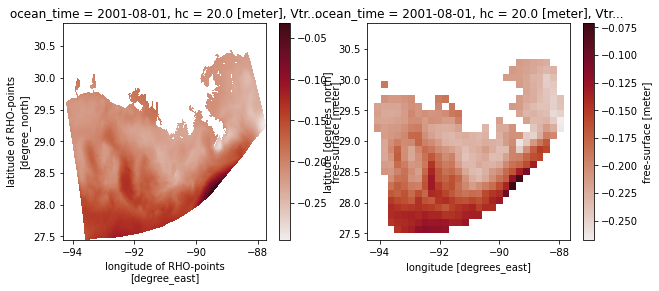

In [20]:
varname = zeta

# sel
longitude = np.linspace(ds.cf[varname].cf['longitude'].min(), ds.cf[varname].cf['longitude'].max(), 30)
latitude = np.linspace(ds.cf[varname].cf['latitude'].min(), ds.cf[varname].cf['latitude'].max(), 30)

# isel
iZ = None
iT = 0
isel = dict(T=iT)

da_out = ds.cf[varname].em.interp2d(longitude, latitude, iT=iT, iZ=iZ, locstream=False, extrap=False, extrap_val=np.nan)

# plot
cmap = cmo.delta
dacheck = ds.cf[varname].cf.isel(isel)

fig, axes = plt.subplots(1,2, figsize=(10,4))
dacheck.cmo.cfplot(ax=axes[0], x='longitude', y='latitude')
da_out.cmo.cfplot(ax=axes[1], x='longitude', y='latitude')


## MOM6

In [21]:
dataurl = 'http://35.188.34.63:8080/thredds/dodsC/OM4p5/'

ds = xr.open_dataset(f'{dataurl}/ocean_monthly_z.200301-200712.nc4',
                     chunks={'time':1, 'z_l': 1}, drop_variables=['average_DT',
                                                                  'average_T1',
                                                                  'average_T2'])
ds

<xarray.Dataset>
Dimensions:       (nv: 2, xh: 720, xq: 720, yh: 576, yq: 576, z_i: 36, z_l: 35,
                   time: 60)
Coordinates:
  * nv            (nv) float64 1.0 2.0
  * xh            (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * xq            (xq) float64 -299.5 -299.0 -298.5 -298.0 ... 59.0 59.5 60.0
  * yh            (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
  * yq            (yq) float64 -77.82 -77.63 -77.45 -77.26 ... 89.58 89.79 90.0
  * z_i           (z_i) float64 0.0 5.0 15.0 25.0 ... 5.75e+03 6.25e+03 6.75e+03
  * z_l           (z_l) float64 2.5 10.0 20.0 32.5 ... 5.5e+03 6e+03 6.5e+03
  * time          (time) object 2003-01-16 12:00:00 ... 2007-12-16 12:00:00
Data variables: (12/36)
    Coriolis      (yq, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    areacello     (yh, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    areacello_bu  (yq, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    areacello_cu  (yh, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    areacello_cv  (yq, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    deptho        (yh, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    ...            ...
    umo           (time, z_l, yh, xq) float32 dask.array<chunksize=(1, 1, 576, 720), meta=np.ndarray>
    uo            (time, z_l, yh, xq) float32 dask.array<chunksize=(1, 1, 576, 720), meta=np.ndarray>
    vmo           (time, z_l, yq, xh) float32 dask.array<chunksize=(1, 1, 576, 720), meta=np.ndarray>
    vo            (time, z_l, yq, xh) float32 dask.array<chunksize=(1, 1, 576, 720), meta=np.ndarray>
    volcello      (time, z_l, yh, xh) float32 dask.array<chunksize=(1, 1, 576, 720), meta=np.ndarray>
    zos           (time, yh, xh) float32 dask.array<chunksize=(1, 576, 720), meta=np.ndarray>
Attributes:
    filename:                        ocean_monthly.200301-200712.zos.nc
    title:                           OM4p5_IAF_BLING_CFC_abio_csf_mle200
    associated_files:                areacello: 20030101.ocean_static.nc
    grid_type:                       regular
    grid_tile:                       N/A
    external_variables:              areacello
    DODS_EXTRA.Unlimited_Dimension:  time

In [22]:
ds.cf

Coordinates:
- CF Axes: * X: ['xh', 'xq']
           * Y: ['yh', 'yq']
           * Z: ['z_i', 'z_l']
           * T: ['time']

- CF Coordinates: * longitude: ['xh', 'xq']
                  * latitude: ['yh', 'yq']
                  * vertical: ['z_i', 'z_l']
                  * time: ['time']

- Cell Measures:   area, volume: n/a

- Standard Names:   n/a

- Bounds:   n/a

Data Variables:
- Cell Measures:   area: ['areacello']
                   volume: ['volcello']

- Standard Names:   SeaAreaFraction: ['sftof']
                    cell_area: ['areacello', 'areacello_bu', 'areacello_cu', 'areacello_cv']
                    cell_thickness: ['thkcello']
                    ocean_mass_x_transport: ['umo']
                    ocean_mass_y_transport: ['vmo']
                    ocean_volume: ['volcello']
                    sea_floor_depth_below_geoid: ['deptho']
                    sea_surface_height_above_geoid: ['zos']
                    sea_water_potential_temperature: ['thetao']
    

Variables to use

In [23]:
u = 'sea_water_x_velocity'

### grid point

#### horizontal interp, vertical and time isel

In [24]:
varname = u

# sel
longitude = float(ds.cf[varname].cf['X'][100])
latitude = float(ds.cf[varname].cf['Y'][100])
sel = dict(longitude=longitude, latitude=latitude)

# isel
iZ = 0
iT = 0
isel = dict(Z=iZ, T=iT)

da_out = ds.cf[varname].em.interp2d(longitude, latitude, iT=iT, iZ=iZ)

# check
da_check = ds.cf[varname].cf.sel(sel).cf.isel(isel)

assert np.allclose(da_out, da_check)

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:455: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


#### horizontal and vertical interp, time isel

In [25]:
varname = u

# sel
longitude = float(ds.cf[varname].cf['X'][100])
latitude = float(ds.cf[varname].cf['Y'][100])
Z = float(ds.cf[varname].cf['Z'][0])
sel = dict(longitude=longitude, latitude=latitude, Z=Z)

# isel
iT = 0
isel = dict(T=iT)

da_out = ds.cf[varname].em.interp2d(longitude, latitude, iT=iT, Z=Z)

# check
da_check = ds.cf[varname].cf.sel(sel).cf.isel(isel)

assert np.allclose(da_out, da_check)

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:455: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


### not grid point

#### inside domain

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:455: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


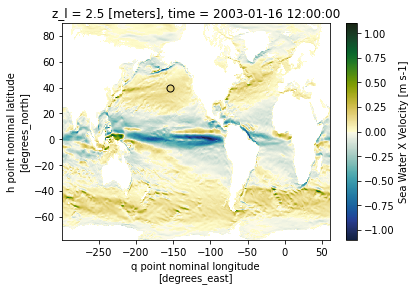

In [26]:
varname = u

# sel
longitude = -155
latitude = 40
sel = dict(longitude=longitude, latitude=latitude)

# isel
iZ = 0
iT = 0
isel = dict(Z=iZ, T=iT)

da_out = ds.cf[varname].em.interp2d(longitude, latitude, iT=iT, iZ=iZ)

# plot
cmap = cmo.delta
dacheck = ds.cf[varname].cf.isel(isel)
fig, ax = plt.subplots(1,1)
dacheck.cmo.plot(ax=ax)
ax.scatter(da_out.cf['longitude'], da_out.cf['latitude'], s=50, c=da_out, 
           vmin=dacheck.min().values, vmax=dacheck.max().values, cmap=cmap, edgecolors='k')

#### outside domain

Skipping this section since the model output is global.

### points (locstream)

Unstructured pairs of lon/lat locations instead of grids of lon/lat locations, using `locstream`.

In [27]:
varname = u

# sel
# this creates 12 pairs of lon/lat points that 
# align with grid points so we can check the 
# interpolation
longitude = ds.cf[varname].cf['X'][::26].values
latitude = ds.cf[varname].cf['Y'][::21].values
# selecting individual lon/lat locations with advanced xarray indexing
sel = dict(longitude=xr.DataArray(longitude, dims="pts"), latitude=xr.DataArray(latitude, dims="pts"))

# isel
iZ = 1
iT = 0
isel = dict(Z=iZ, T=iT)

da_out = ds.cf[varname].em.interp2d(longitude, latitude, iT=iT, iZ=iZ, locstream=True)

# check
da_check = ds.cf[varname].cf.isel(isel).cf.sel(sel)

assert np.allclose(da_out, da_check, equal_nan=True)

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:455: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


### grid of known locations

In [28]:
varname = u

# sel
longitude = ds.cf[varname].cf['X'][100:105]
latitude = ds.cf[varname].cf['Y'][100:106]
sel = dict(longitude=longitude, latitude=latitude)

# isel
iZ = 0
iT = 0
isel = dict(Z=iZ, T=iT)

da_out = ds.cf[varname].em.interp2d(longitude, latitude, iT=iT, iZ=iZ, locstream=False)

# check
da_check = ds.cf[varname].cf.sel(sel).cf.isel(isel)

assert np.allclose(da_out, da_check)

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:455: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


### grid of new locations

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:455: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


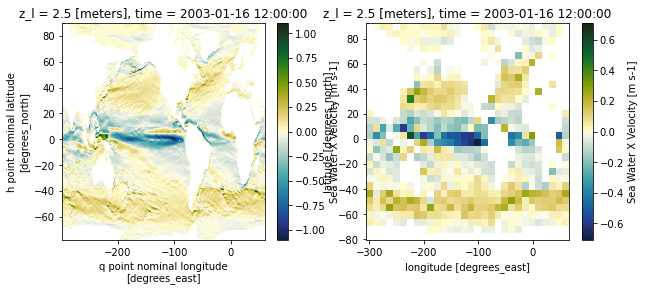

In [29]:
varname = u

# sel
longitude = np.linspace(ds.cf[varname].cf['X'].min(), ds.cf[varname].cf['X'].max(), 30)
latitude = np.linspace(ds.cf[varname].cf['Y'].min(), ds.cf[varname].cf['Y'].max(), 30)
sel = dict(longitude=longitude, latitude=latitude)

# isel
iZ = 0
iT = 0
isel = dict(Z=iZ, T=iT)

da_out = ds.cf[varname].em.interp2d(longitude, latitude, iT=iT, iZ=iZ, extrap=False, extrap_val=np.nan)

# plot
cmap = cmo.delta
dacheck = ds.cf[varname].cf.isel(isel)

fig, axes = plt.subplots(1,2, figsize=(10,4))
dacheck.cmo.plot(ax=axes[0])
da_out.cmo.plot(ax=axes[1])


## HYCOM

In [30]:
# url = ['http://tds.hycom.org/thredds/dodsC/GLBy0.08/latest']
# ds = xr.open_mfdataset(url, preprocess=em.preprocess, drop_variables='tau')
# ds.isel(time=slice(0,2)).sel(lat=slice(-20, 30), lon=slice(140,190)).to_netcdf('hycom.nc')
ds = xr.open_mfdataset('hycom.nc', preprocess=em.preprocess)

In [31]:
ds.cf

Coordinates:
- CF Axes: * X: ['lon']
           * Y: ['lat']
           * Z: ['depth']
           * T: ['time']

- CF Coordinates: * longitude: ['lon']
                  * latitude: ['lat']
                  * vertical: ['depth']
                  * time: ['time']

- Cell Measures:   area, volume: n/a

- Standard Names: * depth: ['depth']
                    forecast_reference_time: ['time_run']
                  * latitude: ['lat']
                  * longitude: ['lon']
                  * time: ['time']

- Bounds:   n/a

Data Variables:
- Cell Measures:   area, volume: n/a

- Standard Names:   eastward_sea_water_velocity: ['water_u']
                    eastward_sea_water_velocity_at_bottom: ['water_u_bottom']
                    forecast_period: ['time_offset']
                    northward_sea_water_velocity: ['water_v']
                    northward_sea_water_velocity_at_bottom: ['water_v_bottom']
                    sea_surface_elevation: ['surf_el']
                    sea_water

Variable to use

In [32]:
u = 'eastward_sea_water_velocity'

### grid point

In [33]:
varname = u

# sel
longitude = float(ds.cf[varname].cf['X'][100])
latitude = float(ds.cf[varname].cf['Y'][150])
sel = dict(longitude=longitude, latitude=latitude)

# isel
iZ = 0
iT = None
isel = dict(Z=iZ)

da_out = ds.cf[varname].em.interp2d(longitude, latitude, iT=iT, iZ=iZ)

# check
da_check = ds.cf[varname].cf.sel(sel).cf.isel(isel)

assert np.allclose(da_out, da_check)

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/cf_xarray/accessor.py:1628: UserWarning: Variables {''} not found in object but are referred to in the CF attributes.
  warnings.warn(
/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:455: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/cf_xarray/accessor.py:1628: UserWarning: Variables {''} not found in object but are referred to in the CF attributes.
  warnings.warn(


### not grid point

#### inside domain

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:455: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/cf_xarray/accessor.py:1628: UserWarning: Variables {''} not found in object but are referred to in the CF attributes.
  warnings.warn(


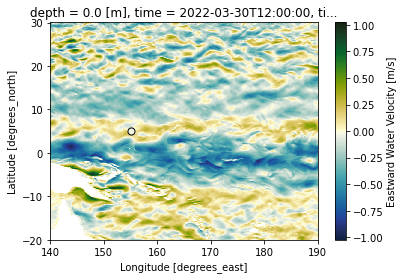

In [34]:
varname = u

# sel
longitude = 155
latitude = 5
sel = dict(longitude=longitude, latitude=latitude)

# isel
iZ = 0
iT = 0
isel = dict(Z=iZ, T=iT)

da_out = ds.cf[varname].em.interp2d(longitude, latitude, iT=iT, iZ=iZ)

# plot
cmap = cmo.delta
dacheck = ds.cf[varname].cf.isel(isel)
fig, ax = plt.subplots(1,1)
dacheck.cmo.plot(ax=ax)
ax.scatter(da_out.cf['longitude'], da_out.cf['latitude'], s=50, c=da_out, 
           vmin=dacheck.min().values, vmax=dacheck.max().values, cmap=cmap, edgecolors='k')

#### outside domain

Don't extrapolate

This purposefully raises an error so is commented out:
> ValueError: Longitude outside of available domain. Use extrap=True to extrapolate.

In [35]:
# varname = u

# # sel
# longitude = -166
# latitude = 48
# sel = dict(longitude=longitude, latitude=latitude)

# # isel
# iZ = 0
# iT = 0
# isel = dict(Z=iZ, T=iT)

# da_out = ds.cf[varname].em.interp2d(longitude, latitude, iT=iT, iZ=iZ, extrap=False)

# da_out = em.select(**kwargs)
# da_out

Extrapolate

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/cf_xarray/accessor.py:1628: UserWarning: Variables {''} not found in object but are referred to in the CF attributes.
  warnings.warn(
/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:455: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/cf_xarray/accessor.py:1628: UserWarning: Variables {''} not found in object but are referred to in the CF attributes.
  warnings.warn(


(138.0, 190.0)

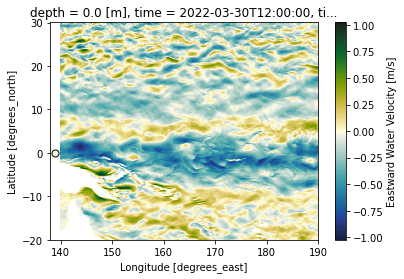

In [36]:
varname = u

# sel
longitude = 139
latitude = 0
sel = dict(longitude=longitude, latitude=latitude)

# isel
iZ = 0
iT = 0
isel = dict(Z=iZ, T=iT)

da_out = ds.cf[varname].em.interp2d(longitude, latitude, iT=iT, iZ=iZ, extrap=True)

# plot
cmap = cmo.delta
dacheck = ds.cf[varname].cf.isel(isel)
fig, ax = plt.subplots(1,1)
dacheck.cmo.plot(ax=ax)
ax.scatter(da_out.cf['longitude'], da_out.cf['latitude'], s=50, c=da_out, 
           vmin=dacheck.min().values, vmax=dacheck.max().values, cmap=cmap, edgecolors='k')

ax.set_xlim(138,190)

### points (locstream)

Unstructured pairs of lon/lat locations instead of grids of lon/lat locations, using `locstream`.

In [37]:
varname = u

# sel
# this creates 12 pairs of lon/lat points that 
# align with grid points so we can check the 
# interpolation
longitude = ds.cf[varname].cf['X'][::40].values
latitude = ds.cf[varname].cf['Y'][::80].values
# selecting individual lon/lat locations with advanced xarray indexing
sel = dict(longitude=xr.DataArray(longitude, dims="pts"), latitude=xr.DataArray(latitude, dims="pts"))

# isel
iZ = 0
iT = 0
isel = dict(Z=iZ, T=iT)

da_out = ds.cf[varname].em.interp2d(longitude, latitude, iT=iT, iZ=iZ, locstream=True)

# check
da_check = ds.cf[varname].cf.isel(isel).cf.sel(sel)

assert np.allclose(da_out, da_check, equal_nan=True)

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/cf_xarray/accessor.py:1628: UserWarning: Variables {''} not found in object but are referred to in the CF attributes.
  warnings.warn(
/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:455: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/cf_xarray/accessor.py:1628: UserWarning: Variables {''} not found in object but are referred to in the CF attributes.
  warnings.warn(


### grid of known locations

In [38]:
varname = u

# sel
longitude = ds.cf[varname].cf['X'][100::500]
latitude = ds.cf[varname].cf['Y'][100::500]
sel = dict(longitude=longitude, latitude=latitude)

# isel
iZ = 0
iT = None
isel = dict(Z=iZ)

da_out = ds.cf[varname].em.interp2d(longitude, latitude, iT=iT, iZ=iZ, locstream=False)

# check
da_check = ds.cf[varname].cf.sel(sel).cf.isel(isel)

assert np.allclose(da_out, da_check)

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/cf_xarray/accessor.py:1628: UserWarning: Variables {''} not found in object but are referred to in the CF attributes.
  warnings.warn(
/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:455: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/cf_xarray/accessor.py:1628: UserWarning: Variables {''} not found in object but are referred to in the CF attributes.
  warnings.warn(


### grid of new locations

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/cf_xarray/accessor.py:1628: UserWarning: Variables {''} not found in object but are referred to in the CF attributes.
  warnings.warn(
/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/cf_xarray/accessor.py:1628: UserWarning: Variables {''} not found in object but are referred to in the CF attributes.
  warnings.warn(
/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/cf_xarray/accessor.py:1628: UserWarning: Variables {''} not found in object but are referred to in the CF attributes.
  warnings.warn(
/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/cf_xarray/accessor.py:1628: UserWarning: Variables {''} not found in object but are referred to in the CF attributes.
  warnings.warn(
/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/cf_xarray/accessor.py:1628: UserWarning: Variables {''} not found in object but are referred to in t

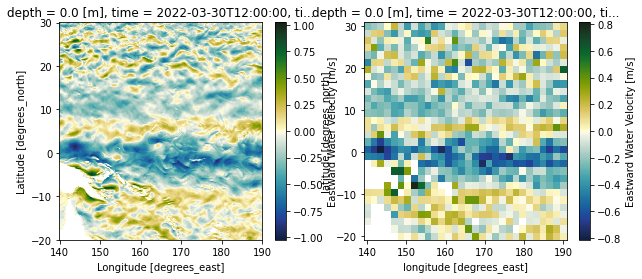

In [39]:
varname = u

# sel
longitude = np.linspace(ds.cf[varname].cf['X'].min(), ds.cf[varname].cf['X'].max(), 30)
latitude = np.linspace(ds.cf[varname].cf['Y'].min(), ds.cf[varname].cf['Y'].max(), 30)
sel = dict(longitude=longitude, latitude=latitude)

# isel
iZ = 0
iT = 0
isel = dict(Z=iZ, T=iT)

da_out = ds.cf[varname].em.interp2d(longitude, latitude, iT=iT, iZ=iZ, locstream=False)
# kwargs = dict(da=ds[varname], longitude=longitude, latitude=latitude, iT=T, iZ=Z)

# da_out = em.select(**kwargs)

# plot
cmap = cmo.delta
dacheck = ds.cf[varname].cf.isel(isel)

fig, axes = plt.subplots(1,2, figsize=(10,4))
dacheck.cmo.plot(ax=axes[0])
da_out.cmo.plot(ax=axes[1])


## POM

In [40]:
try:
    url = ['https://opendap.co-ops.nos.noaa.gov/thredds/dodsC/LOOFS/fmrc/Aggregated_7_day_LOOFS_Fields_Forecast_best.ncd']
    ds = xr.open_mfdataset(url, preprocess=em.preprocess)
except OSError:
    import pandas as pd
    today = pd.Timestamp.today()
    url = [today.strftime('https://opendap.co-ops.nos.noaa.gov/thredds/dodsC/NOAA/LOOFS/MODELS/%Y/%m/%d/glofs.loofs.fields.nowcast.%Y%m%d.t00z.nc'),
           today.strftime('https://opendap.co-ops.nos.noaa.gov/thredds/dodsC/NOAA/LOOFS/MODELS/%Y/%m/%d/glofs.loofs.fields.nowcast.%Y%m%d.t06z.nc')]
    ds = xr.open_mfdataset(url, preprocess=em.preprocess)
ds

oc_open: server error retrieving url: code=500 message="null"

<xarray.Dataset>
Dimensions:    (time: 12, ny: 25, nx: 61, sigma: 20)
Coordinates:
  * time       (time) datetime64[ns] 2022-08-15T18:59:45.937500032 ... 2022-0...
    lon        (ny, nx) float32 dask.array<chunksize=(25, 61), meta=np.ndarray>
    lat        (ny, nx) float32 dask.array<chunksize=(25, 61), meta=np.ndarray>
  * sigma      (sigma) float32 0.0 0.0227 0.0454 0.0681 ... 0.8853 0.9534 1.0
  * nx         (nx) int64 0 1 2 3 4 5 6 7 8 9 ... 51 52 53 54 55 56 57 58 59 60
  * ny         (ny) int64 0 1 2 3 4 5 6 7 8 9 ... 15 16 17 18 19 20 21 22 23 24
    z          (time, sigma, ny, nx) float32 dask.array<chunksize=(6, 20, 25, 61), meta=np.ndarray>
Data variables:
    validtime  (time) |S64 dask.array<chunksize=(6,), meta=np.ndarray>
    mask       (time, ny, nx) float32 dask.array<chunksize=(6, 25, 61), meta=np.ndarray>
    depth      (time, ny, nx) float32 dask.array<chunksize=(6, 25, 61), meta=np.ndarray>
    zeta       (time, ny, nx) float32 dask.array<chunksize=(6, 25, 61), meta=np.ndarray>
    air_u      (time, ny, nx) float32 dask.array<chunksize=(6, 25, 61), meta=np.ndarray>
    air_v      (time, ny, nx) float32 dask.array<chunksize=(6, 25, 61), meta=np.ndarray>
    u          (time, sigma, ny, nx) float32 dask.array<chunksize=(6, 20, 25, 61), meta=np.ndarray>
    v          (time, sigma, ny, nx) float32 dask.array<chunksize=(6, 20, 25, 61), meta=np.ndarray>
    temp       (time, sigma, ny, nx) float32 dask.array<chunksize=(6, 20, 25, 61), meta=np.ndarray>
Attributes: (12/17)
    datum1:                          reference to LWD=zeta
    datum2:                          reference to IGLD85=zeta - IGLD85
    file_type:                       Full_Grid
    Conventions:                     COARDS
    grid_type:                       rectilinear
    z_type:                          2-D
    ...                              ...
    history:                         Operation-CO-OPS
    references:                      greg.mott@noaa.gov
    creation_date:                   2022-08-16  0:50:12  00:00
    DODS.strlen:                     19
    DODS.dimName:                    validtime_len
    DODS_EXTRA.Unlimited_Dimension:  time

In [41]:
ds.cf

Coordinates:
- CF Axes: * X: ['nx']
           * Y: ['ny']
           * Z: ['sigma']
           * T: ['time']

- CF Coordinates:   longitude: ['lon']
                    latitude: ['lat']
                    vertical: ['z']
                  * time: ['time']

- Cell Measures:   area, volume: n/a

- Standard Names:   latitude: ['lat']
                    longitude: ['lon']
                  * ocean_sigma_coordinate: ['sigma']
                  * time: ['time']

- Bounds:   n/a

Data Variables:
- Cell Measures:   area, volume: n/a

- Standard Names:   depth: ['depth']
                    eastward_sea_water_velocity: ['u']
                    eastward_wind: ['air_u']
                    northward_sea_water_velocity: ['v']
                    northward_wind: ['air_v']
                    sea_surface_elevation: ['zeta']
                    sea_water_temperature: ['temp']

- Bounds:   n/a

Variables to use

In [42]:
zeta = 'sea_surface_elevation'
temp = 'sea_water_temperature'

### grid point

In [43]:
%%time
varname = zeta

# Set up a single lon/lat location
j, i = 10, 10
longitude = float(ds.cf[varname].cf['longitude'][j,i])
latitude = float(ds.cf[varname].cf['latitude'][j,i])

# Select-by-index a time index and no vertical index (zeta has none)
# also lon/lat by index
Z = None
iT = 0
isel = dict(T=iT, X=i, Y=j)

da_out = ds.cf[varname].em.interp2d(longitude, latitude, iT=iT, iZ=Z)

# check work
da_check = ds.cf[varname].cf.isel(isel)

assert np.allclose(da_out, da_check)

CPU times: user 188 ms, sys: 6.3 ms, total: 195 ms
Wall time: 309 ms


/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:455: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


This is faster the second time the regridder is used — it is saved by the `extract_model` accessor and reused if the lon/lat locations to be interpolated to are the same. Here we interpolate to salinity and it is faster than it was the first time it was used for interpolation the sea surface elevation.

In [44]:
varname = temp

# Set up a single lon/lat location
j, i = 10, 10
longitude = float(ds.cf[varname].cf['longitude'][j,i])
latitude = float(ds.cf[varname].cf['latitude'][j,i])

# Select-by-index a time index and no vertical index (zeta has none)
# also lon/lat by index
iZ = 0
iT = 0
isel = dict(T=iT, Z=iZ, X=i, Y=j)

da_out = ds.cf[varname].em.interp2d(longitude, latitude, iT=iT, iZ=iZ)

# check work
da_check = ds.cf[varname].cf.isel(isel)

assert np.allclose(da_out, da_check)

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:455: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


### not grid point

#### inside domain

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:455: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


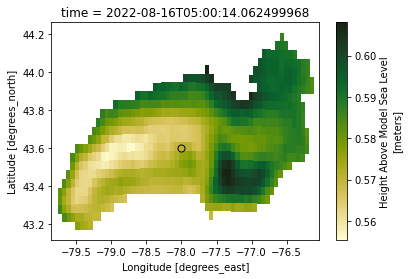

In [45]:
varname = zeta

# sel
longitude = -78.0
latitude = 43.6

# isel
iZ = None
iT = 10
isel = dict(T=iT)

da_out = ds.cf[varname].em.interp2d(longitude, latitude, iT=iT, iZ=iZ)

# plot
cmap = ds.cf[varname].cmo.seq
dacheck = ds.cf[varname].cf.isel(isel)
fig, ax = plt.subplots(1,1)
dacheck.cmo.cfplot(ax=ax, x='longitude', y='latitude')
ax.scatter(da_out.cf['longitude'], da_out.cf['latitude'], s=50, c=da_out, 
           vmin=dacheck.min().values, vmax=dacheck.max().values, cmap=cmap, edgecolors='k')

### points (locstream)

Unstructured pairs of lon/lat locations instead of grids of lon/lat locations, using `locstream`.

In [46]:
varname = zeta

# sel
# this creates 12 pairs of lon/lat points that 
# align with grid points so we can check the 
# interpolation
longitude = ds.cf[varname].cf['longitude'].cf.isel(Y=20, X=slice(None, None, 10))
latitude = ds.cf[varname].cf['latitude'].cf.isel(Y=20, X=slice(None, None, 10))
sel = dict(X=longitude.cf['X'], Y=longitude.cf['Y'])

# isel
iZ = None
iT = 0
isel = dict(T=iT)

da_out = ds.cf[varname].em.interp2d(longitude, latitude, iT=iT, iZ=iZ, locstream=True)

# check
da_check = ds.cf[varname].cf.isel(isel).cf.sel(sel)

assert np.allclose(da_out, da_check, equal_nan=True)

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:455: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


### grid of new locations

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:455: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


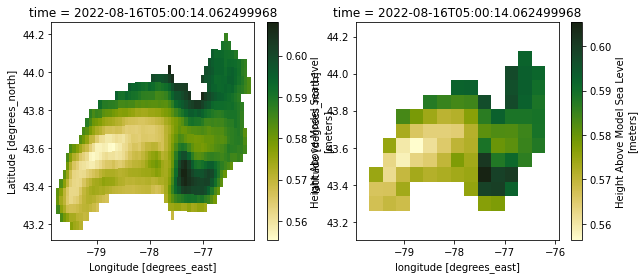

In [47]:
varname = zeta

# sel
longitude = np.linspace(ds.cf[varname].cf['longitude'].min(), ds.cf[varname].cf['longitude'].max(), 15)
latitude = np.linspace(ds.cf[varname].cf['latitude'].min(), ds.cf[varname].cf['latitude'].max(), 15)

# isel
iZ = None
iT = 10
isel = dict(T=iT)

da_out = ds.cf[varname].em.interp2d(longitude, latitude, iT=iT, iZ=iZ, locstream=False, extrap=False, extrap_val=np.nan)

# plot
cmap = cmo.delta
dacheck = ds.cf[varname].cf.isel(isel)

fig, axes = plt.subplots(1,2, figsize=(10,4))
dacheck.cmo.cfplot(ax=axes[0], x='longitude', y='latitude')
da_out.cmo.cfplot(ax=axes[1], x='longitude', y='latitude')
